In [17]:
%pip install matplotlib
%pip install fastf1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
#The packages needed are imported
import fastf1 as ff1
from fastf1 import plotting
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

In [19]:
# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

# Setup plotting
plotting.setup_mpl()

In [20]:
# Parameters
year = 2024
ses = 'Q'
driver = 'VER'
circuit = 2
colormap = mpl.cm.plasma

In [21]:
# We choose the session and load it
session = ff1.get_session(year, circuit, ses)
weekend = session.event
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req           

In [22]:
# We choose the driver and obtain his best lap
fastest_driver = session.laps.pick_driver(driver).pick_fastest()
lap = fastest_driver
# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on
telemetry_driver = fastest_driver.get_telemetry().add_distance()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [23]:
v = telemetry_driver['Speed'] / 3.6    # Speed in m/s
time_float = telemetry_driver['Time'] / np.timedelta64(1, 's')    # Time as a float variable

# We calculate the longitudinal acceleration and filter it
ax = np.gradient(v)/np.gradient(time_float)
ax_smooth = np.convolve(ax, np.ones((3,))/3, mode = 'same')

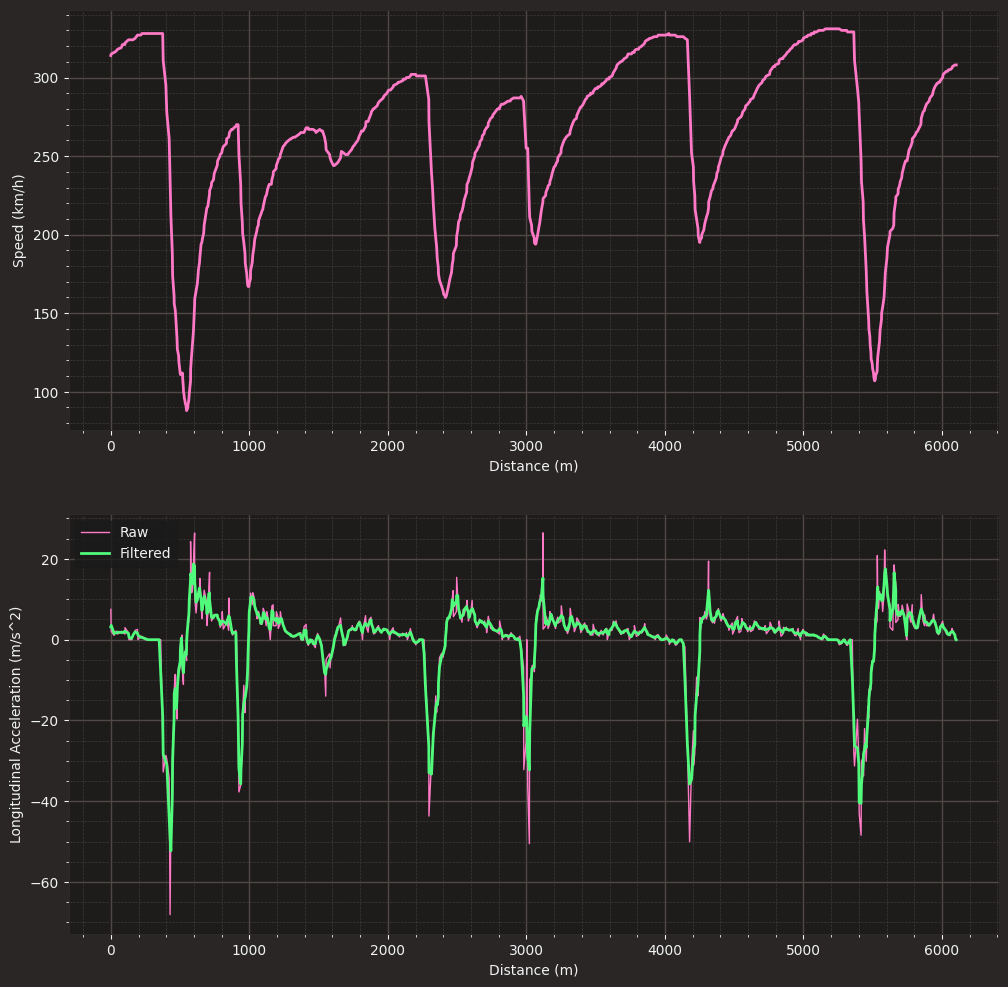

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax, linewidth = 1, label = 'Raw')
axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2, label = 'Filtered')
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")
axes[1].legend()

In [25]:
# I Model: Static Weight Only

m = 798    #kg
g = 9.81

staticWeightTot = m*g

fractionWeightFront = 0.46

staticWeightFront = fractionWeightFront*staticWeightTot
staticWeightRear  = staticWeightTot - staticWeightFront

# The static weights are converted to a (constant) time signal 
loadFront_staticModel = [staticWeightFront] * len(telemetry_driver['Distance'])
loadRear_staticModel  = [staticWeightRear]  * len(telemetry_driver['Distance'])

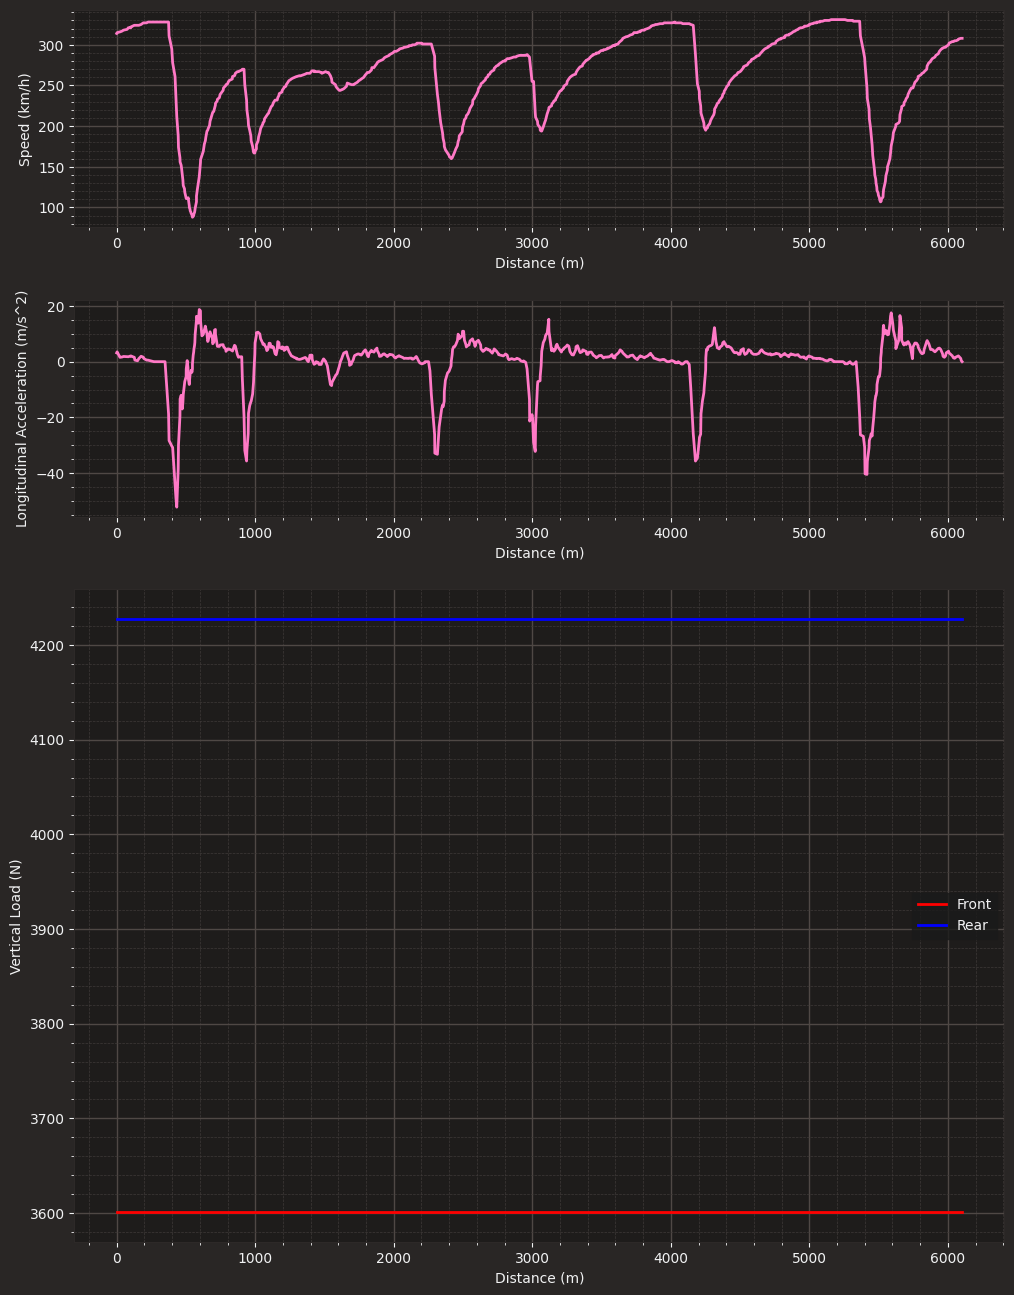

In [26]:
plot_ratios = [1, 1, 3]

fig, axes = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [27]:
# II Model: Inertial Load Transfer added
CoGheight = 0.25   #m
wheelbase = 3.6    #m

deltaLoad = -CoGheight/wheelbase*m*ax_smooth    #Positive Longitudinal Acceleration -> Load shifts to the rear axle (deltaLoad < 0)

loadFront_loadTransferModel = staticWeightFront + deltaLoad
loadRear_loadTransferModel  = staticWeightRear  - deltaLoad

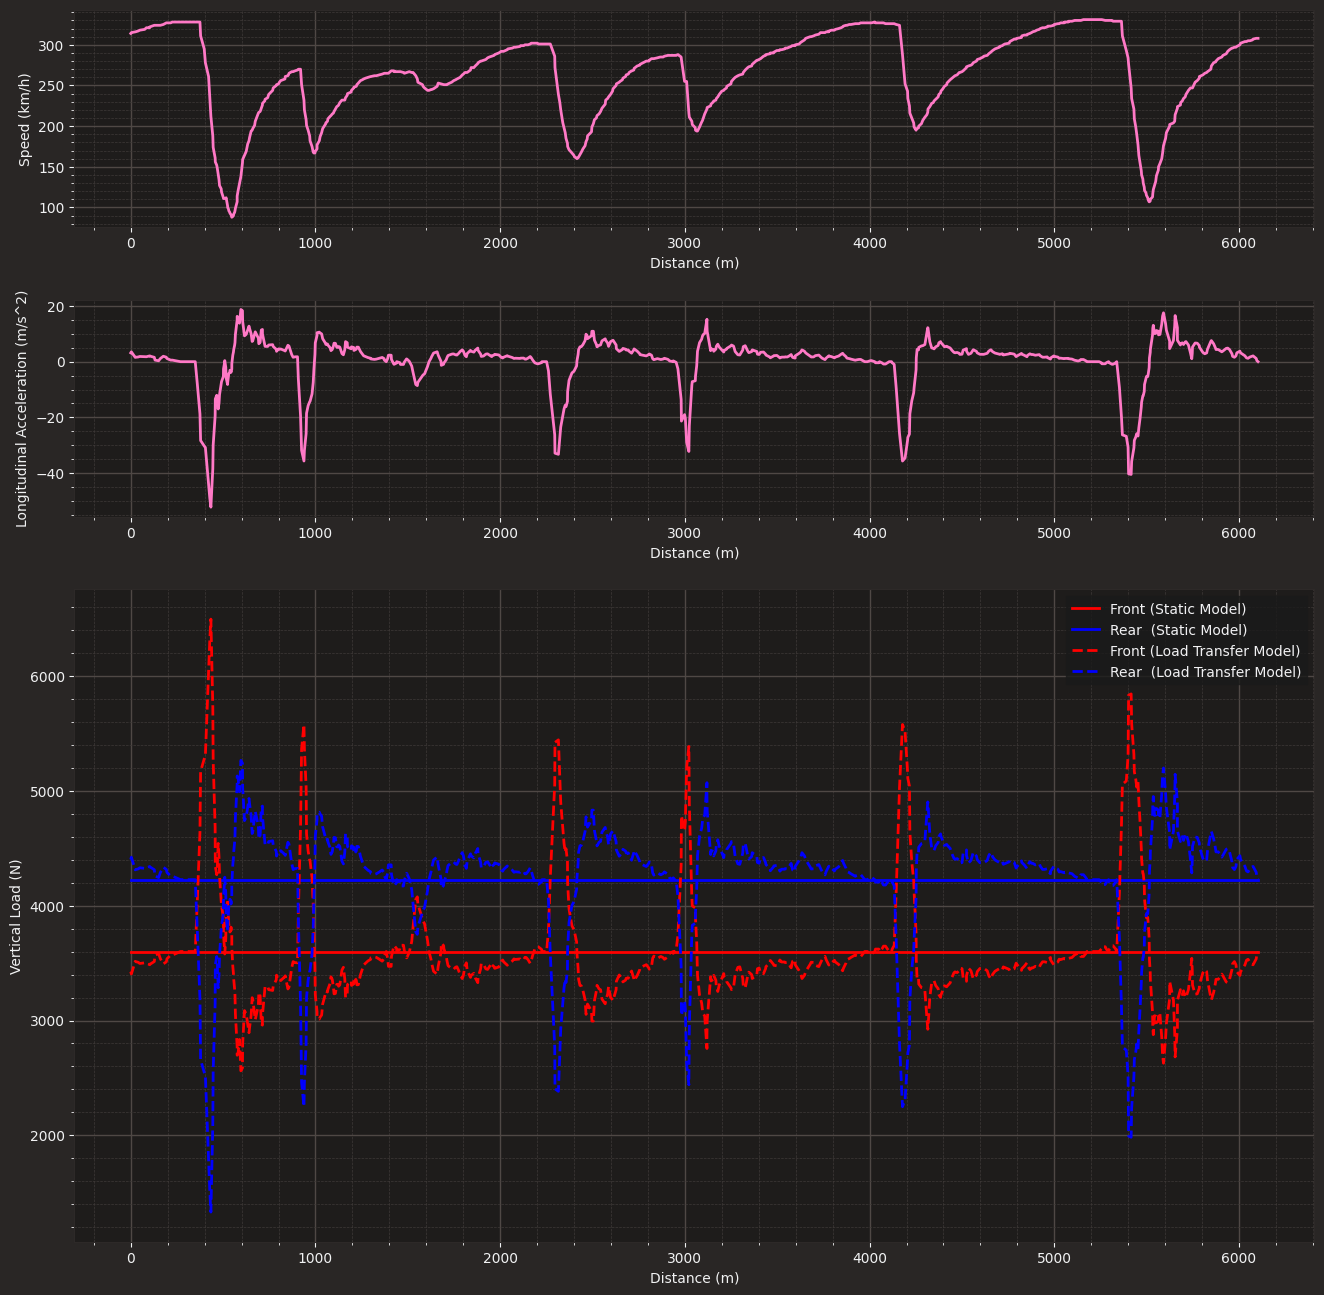

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear  (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferModel, '--r', linewidth = 2, label = 'Front (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferModel, '--b',  linewidth = 2, label = 'Rear  (Load Transfer Model)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [29]:
# III Model: the effect of drag and downforce are added

rho = 1.225
CdA = 1.7               #Drag Coefficient * Frontal Area
efficiency = 3.7
ClA = efficiency*CdA    #Downforce Coefficient * Frontal Area

dragHeight = 0.5 #Height at which the drag force is applied

# We compute the drag and downforce
dragForce = 0.5*CdA*rho*np.square(v)
downForce = 0.5*ClA*rho*np.square(v)

fractionDownforceFront = 0.4    # Front downforce as a fraction of the total downforce (Aero balance)

downForceFront = fractionDownforceFront*downForce
downForceRear = (1 - fractionDownforceFront)*downForce

deltaLoadbyDrag = - dragHeight/wheelbase*dragForce    #Always negative: the drag shifts the load from the front to the rear!

loadFront_loadTransferAeroModel = loadFront_loadTransferModel + downForceFront + deltaLoadbyDrag
loadRear_loadTransferAeroModel  = loadRear_loadTransferModel  + downForceRear  - deltaLoadbyDrag

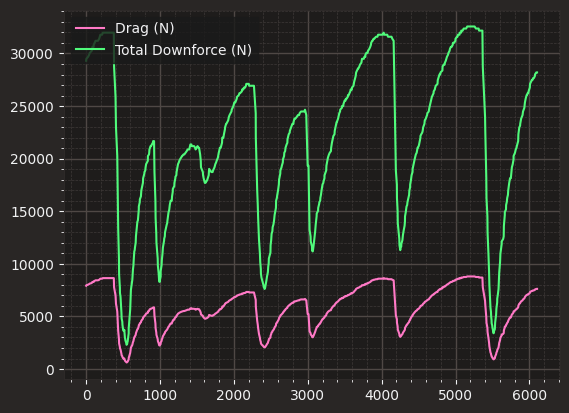

In [30]:
fig, axes = plt.subplots(1)
plt.plot(telemetry_driver['Distance'], dragForce, label = 'Drag (N)')
plt.plot(telemetry_driver['Distance'], downForce, label = 'Total Downforce (N)')
plt.legend()

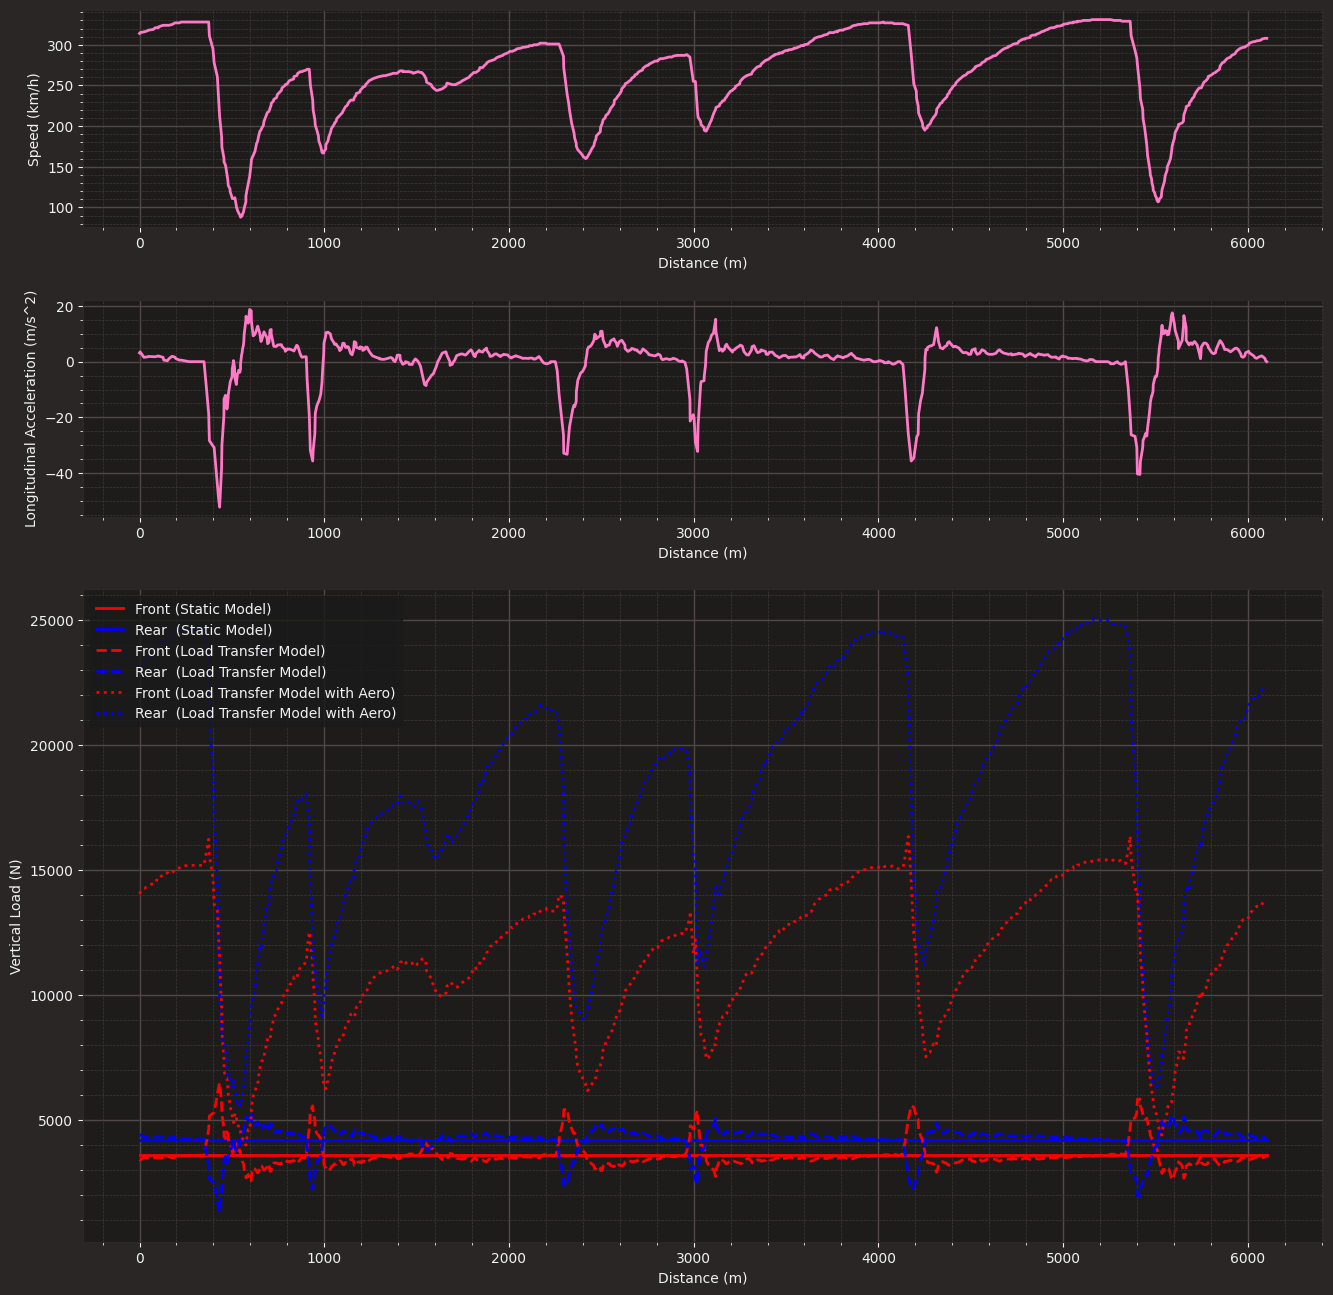

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear  (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferModel, '--r', linewidth = 2, label = 'Front (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferModel, '--b',  linewidth = 2, label = 'Rear  (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel, ':r', linewidth = 2, label = 'Front (Load Transfer Model with Aero)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel, ':b',  linewidth = 2, label = 'Rear  (Load Transfer Model with Aero)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [32]:
def computeLoads(v, ax_smooth, m, fractionWeightFront, CoGheight, wheelbase, CdA, ClA, dragHeight, fractionDownforceFront):

    staticWeightTot = m*g

    staticWeightFront = fractionWeightFront*staticWeightTot
    staticWeightRear = (1 - fractionWeightFront)*staticWeightTot

    # The static weights are converted to a (constant) time signal 
    loadFront_staticModel = [staticWeightFront] * len(v)
    loadRear_staticModel  = [staticWeightRear]  * len(v)
    
    
    deltaLoad = -CoGheight/wheelbase*m*ax_smooth    #Positive Longitudinal Acceleration -> Load shifts to the rear axle (deltaLoad < 0)

    loadFront_loadTransferModel = staticWeightFront + deltaLoad
    loadRear_loadTransferModel  = staticWeightRear  - deltaLoad
    
    dragForce = 0.5*CdA*rho*np.square(v)
    downForce = 0.5*ClA*rho*np.square(v)

    downForceFront = fractionDownforceFront*downForce
    downForceRear = (1 - fractionDownforceFront)*downForce

    deltaLoadbyDrag = - dragHeight/wheelbase*dragForce    #Always negative: the drag shifts the load from the front to the rear!

    loadFront_loadTransferAeroModel = loadFront_loadTransferModel + downForceFront + deltaLoadbyDrag
    loadRear_loadTransferAeroModel  = loadRear_loadTransferModel  + downForceRear  - deltaLoadbyDrag
    
    return(loadFront_loadTransferAeroModel, loadRear_loadTransferAeroModel)

In [33]:
loadFront_loadTransferAeroModel_default, loadRear_loadTransferAeroModel_default =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m,
                                                                                                fractionWeightFront,
                                                                                                CoGheight,
                                                                                                wheelbase,
                                                                                                CdA,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)


loadFront_loadTransferAeroModel_higherMass, loadRear_loadTransferAeroModel_higherMass =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m + 100,
                                                                                                fractionWeightFront,
                                                                                                CoGheight,
                                                                                                wheelbase,
                                                                                                CdA,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)

loadFront_loadTransferAeroModel_higherDrag, loadRear_loadTransferAeroModel_higherDrag =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m,
                                                                                                fractionWeightFront,
                                                                                                CoGheight,
                                                                                                wheelbase,
                                                                                                CdA*1.2,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)

loadFront_loadTransferAeroModel_higherCoG, loadRear_loadTransferAeroModel_higherCoG =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m,
                                                                                                fractionWeightFront,
                                                                                                CoGheight*1.2,
                                                                                                wheelbase,
                                                                                                CdA,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)

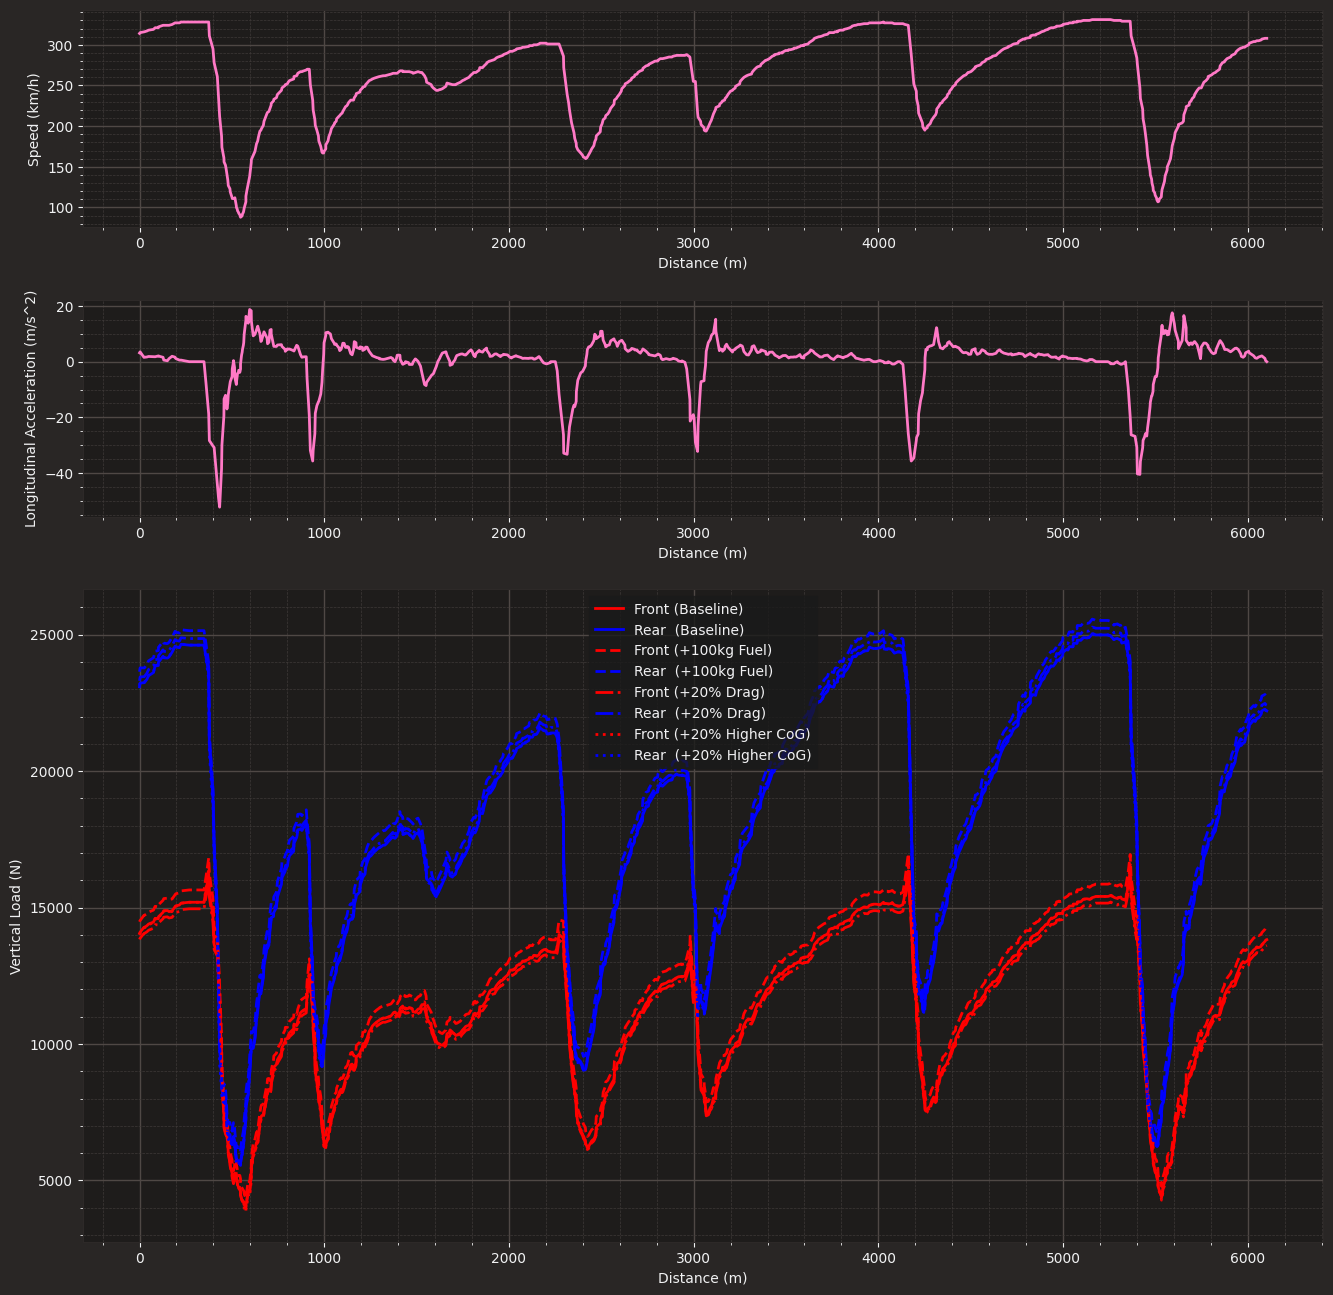

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_default, 'r',      linewidth = 2, label = 'Front (Baseline)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_default, 'b',       linewidth = 2, label = 'Rear  (Baseline)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_higherMass, '--r', linewidth = 2, label = 'Front (+100kg Fuel)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_higherMass, '--b',  linewidth = 2, label = 'Rear  (+100kg Fuel)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_higherDrag, '-.r', linewidth = 2, label = 'Front (+20% Drag)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_higherDrag, '-.b',  linewidth = 2, label = 'Rear  (+20% Drag)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_higherCoG, ':r',   linewidth = 2, label = 'Front (+20% Higher CoG)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_higherCoG,  ':b',   linewidth = 2, label = 'Rear  (+20% Higher CoG)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

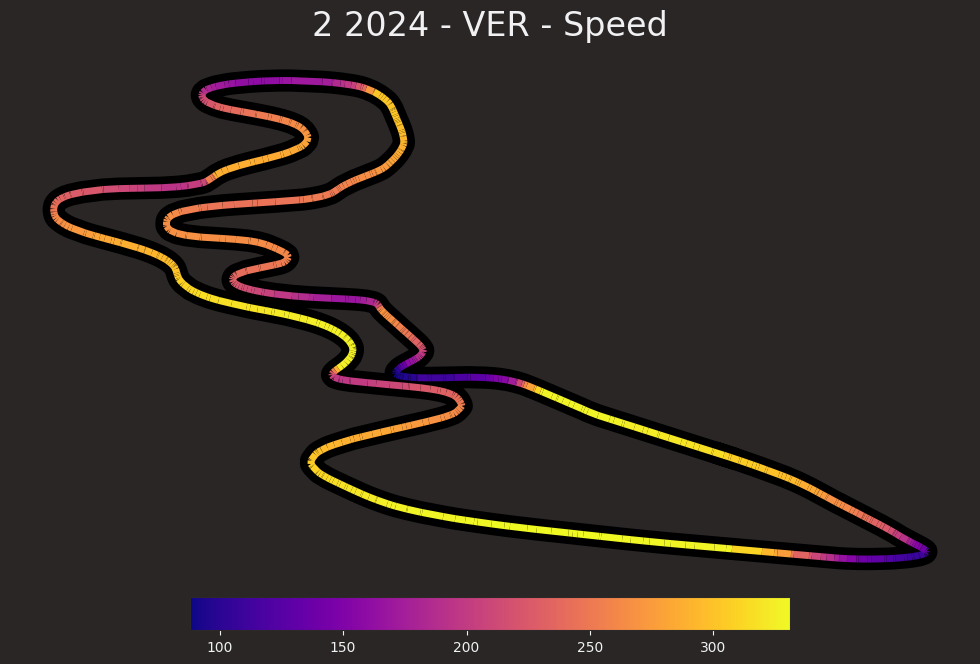

In [35]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{weekend.name} {year} - {driver} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')


# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")


# Show the plot
plt.show()